In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [ ]:
img = cv2.imread('tiny_check.jpg')

In [ ]:
print type(img)

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
print np.amax(img)

In [ ]:
# for quick reference - cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) → dst
#compare with matlab usage: 
blurred = cv2.GaussianBlur(img, (3,3), 2)
plt.imshow(blurred)
plt.show()

In [ ]:
#What else do we need?
#We need to define transforms and apply transforms in a good way

In [ ]:
#cv2.getRotationMatrix2D(center, angle, scale) 
rm = cv2.getRotationMatrix2D((25,25), 15, 0.5)
print rm

In [ ]:
#cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) 
rotated = cv2.warpAffine(img, rm, (50,50))
plt.imshow(rotated)
plt.show()

In [ ]:
#how to make inverse transform in cv2?
#cv2.invertAffineTransform(M[, iM]) → iM
#cv.Transform(src, dst, transmat, shiftvec=None) → None

rotrans

In [ ]:
def jacobi(du, dv, XData, YData, tau, mode):
    """ jacobi() will calculate the jacobi matrix.
    ------------------------------input--------------------------------------
    du:           m-by-n matrix, derivative along x-axis;
    dv:           m-by-n matrtix, derivative along y-axis;
    UData:        1-by-2 vector, X-range of the image.
    VData:        1-by-2 vector, Y-range of the image.
    tfm_matrix:   3-by-3 matrix, transformation matrix.
    mode:         one of 'affine', 'affine_notranslation', 'homography',
    'homography_notranslation'
    ------------------------------output-------------------------------------
    J:            m-by-n-by-p tensor, jacobi matrix.

    """
    [m, n] = du.shape
    [X0, Y0] = np.meshgrid(range(XData[0],XData[1]+1), range(YData[0],YData[1]+1))

    if mode == 'euclidean':
        tau = [tau]
        J = np.zeros((m, n, 1))
        J[:,:,0] = du * (- X0 * np.sin(tau[0]) - Y0 * np.cos(tau[0])) + dv * (X0 * np.cos(tau[0]) - Y0 * np.sin(tau[0]))
    #if mode == 'affine':  
    
    return J
        

In [ ]:
img = cv2.imread('pisa.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE)
print img.shape

In [ ]:
from scipy.ndimage.filters import sobel
from skimage import transform
from skimage import data, io, filters
XData = [0, 479]
YData = [0, 638]
du = sobel(img, 0)
dv = sobel(img, 1)

In [ ]:
J = jacobi(du, dv, XData, YData, 20, 'euclidean')

In [ ]:
img = cv2.imread('pisa.jpg')
rows,cols,ch = img.shape
 
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
 
M_aff = cv2.getAffineTransform(pts1,pts2)
M = np.eye(3)
M[:2,:] = M_aff
 
dst = cv2.warpPerspective(img,M,(cols,rows))
 
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [ ]:
img = cv2.imread('pisa.jpg')
  
rows,cols,ch = img.shape
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
center= np.zeros((2,1))
center[0] = rows/2
center[1] = cols/2
trans = np.eye(3,3)
trans[:2,2] = -center.reshape(2,)
print trans
print center
MM = M.dot(trans) #TRANSLATION DOESNOT GUARANTEE THAT IT WOULD FIT - IT IS ONLY FOR FINAL FIT, DOES NOT CHANGE transf
#dust = np.zeros((3000,3000,3))
#dst = cv2.warpAffine(img, trans, (2*cols,2*rows))
dst = cv2.warpPerspective(img, M, (4*cols,4*rows), dst=dust, flags=cv2.WARP_INVERSE_MAP)
#trans = np.eye(2,3)
#trans[:2,2] = -center.reshape(2,)
#dst = cv2.warpAffine(dst, trans, (4*cols,4*rows))


In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [ ]:
def search_borders(image, trf_matrix):
    left_up = np.array((0,0, 1))
    left_bot = np.array((0, img.shape[0], 1))
    right_up = np.array((img.shape[1], 0, 1))
    right_bot = np.array((img.shape[1], img.shape[0], 1))
    vertexes = [left_up, left_bot, right_up, right_bot]

    new_vertexes = []

    for ver in vertexes:
        new_ver = trf_matrix.dot(ver)
        new_vertexes.append(new_ver)

    new_vertexes = np.array(new_vertexes) 
    new_vertexes[:,0] /= new_vertexes[:,2]
    new_vertexes[:,1] /= new_vertexes[:,2]
    new_vertexes[:,2] /= new_vertexes[:,2]

    x_min = np.min(new_vertexes[:,0])
    x_max = np.max(new_vertexes[:,0])
    y_min = np.min(new_vertexes[:,1])
    y_max = np.max(new_vertexes[:,1])
    
    return x_min, x_max, y_min, y_max

In [ ]:
from copy import deepcopy
img = cv2.imread('pisa.jpg')
  
rows,cols,ch = img.shape
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
center= np.zeros((2,1))
center[0] = rows/2
center[1] = cols/2
trans = np.eye(3,3)
trans[:2,2] = -center.reshape(2,)
print trans
print center
#MM = M.dot(trans) #TRANSLATION DOESNOT GUARANTEE THAT IT WOULD FIT - IT IS ONLY FOR FINAL FIT, DOES NOT CHANGE transf
#dust = np.zeros((3000,3000,3))
#dst = cv2.warpAffine(img, trans, (2*cols,2*rows))
trans2 = deepcopy(trans)
trans2[:2,2] = center.reshape(2,)
MM = np.linalg.inv(M).dot(trans)
dst = cv2.warpPerspective(img, MM, (cols,rows))#, dst=dust)
#trans = np.eye(2,3)
#trans[:2,2] = -center.reshape(2,)
#dst = cv2.warpAffine(dst, trans, (4*cols,4*rows))

x_min, x_max, y_min, y_max = search_borders(img, MM)

x_scale = img.shape[1] / (x_max - x_min)
y_scale = img.shape[0] / (y_max - y_min)

trans_back = np.eye(3)
trans_back[0,2] = -x_min
trans_back[1,2] = -y_min

trans_backscale = np.eye(3)
trans_backscale[0,0] = x_scale
trans_backscale[1,1] = y_scale


res = np.linalg.inv(M).dot(vec)
img_1 =  cv2.warpPerspective(img, trans_backscale.dot(trans_back.dot(MM)), (cols,rows), dst=dust)
print res

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131),plt.imshow(img),plt.title('Input')
plt.subplot(132),plt.imshow(img_1),plt.title('Input')
plt.subplot(133),plt.imshow(dst),plt.title('Output')
plt.show()

In [36]:
def polina_transform(input_image, tfm_matrix, UData = None, VData = None, XData = None, YData = None, inv_flag = True):
    
    final = np.eye(3)
    
    #first, translate to a new center:
    u_trans = np.eye(3)
    UV_scale = np.eye(3)
    if not UData is None:
        u_trans[0,2] = UData[0]
        u_trans[1,2] = VData[0]
    
        UV_scale[0,0] = (UData[1] - UData[0]) / float(input_image.shape[1])
        UV_scale[1,1] = (VData[1] - VData[0]) / float(input_image.shape[0])
        
    #then apply the transform
    M = np.eye(3)
    if inv_flag:
        M = np.linalg.inv(tfm_matrix)
    else:
        M = tfm_matrix
    
    #then do a transform according to XData and YData
    x_trans = np.eye(3)
    if not XData is None:
        x_trans[0,2] = -XData[0]
        x_trans[1,2] = -YData[0]
    
    final = x_trans.dot(M).dot(u_trans).dot(UV_scale)
    
    if not XData is None:
        destination_size = (np.sum(np.abs(XData)).astype(int),np.sum(np.abs(YData)).astype(int))
    else:
        destination_size = (int(input_image.shape[1] * tfm_matrix[0, 0]), int(input_image.shape[0] *tfm_matrix[1, 1]))
        print destination_size
        
    img_1 =  cv2.warpPerspective(input_image, final, destination_size)
    
    plt.imshow(img_1)
    plt.show()
    print img_1.shape

In [13]:
img = cv2.imread('building1.jpg')

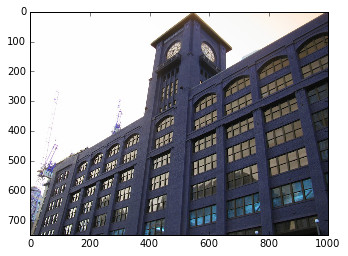

In [30]:
plt.imshow(img)
plt.show()

(500, 75)


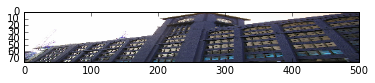

(75, 500, 3)


In [39]:
downsample_matrix = np.array([[0.5, 0, 0], [0, 0.1, 0], [0, 0, 1]])
polina_transform(img, downsample_matrix, inv_flag=False)

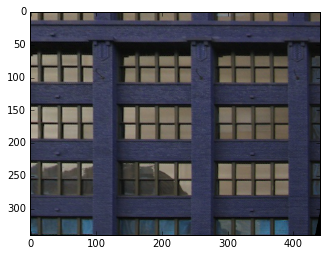

(340, 441, 3)


In [33]:
M = np.asarray([[0.941, 0.0752, -8.263], [-0.3591, 0.9903, -4.4117], [-.0006, -0.0006, 1]])
UData = np.asarray([-746, 253])
VData = np.asarray([-459, 290])
XData = np.asarray([-208 - 20, 208 + 5])
YData = np.asarray([-170, 170])

polina_transform(img, M, UData, VData, XData, YData)

In [ ]:
341 / 417.

In [ ]:
M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])
UData = np.asarray([-318, 320])
VData = np.asarray([-239, 240])
XData = np.asarray([-100, 100])
YData = np.asarray([-100, 100])

polina_transform(img, M, UData, VData, XData, YData)

In [ ]:
check = cv2.imread('building.jpg')


#init_points = np.asarray([[0, check.shape[1]], [0, check.shape[0]]])

#init_points = np.asarray([[60, 80], [60, 80]])

#plt.imshow(check[init_points[0][0]: init_points[0][1], init_points[1][0]: init_points[1][1]])
#plt.show()
plt.imshow(check)
plt.show()

In [ ]:
XData = np.array([-30,31])
YData = np.array([-30,31])
UData = np.array([-13.0, 90.0])
VData = np.array([-13.0, 84.0])
#M = np.asarray([[1., 0, 0.5], [0.2, 1, 0], [0, 0.001, 1]])

In [ ]:
XData = np.array([0,300])
YData = np.array([0, 300])
UData = np.array([0,500])
VData = np.array([0,500])

In [ ]:
polina_transform(check, np.eye(3), UData, VData, XData, YData)

In [ ]:
tr = np.eye(3)
tr[0,2] = 71
tr[1,2] = 22

In [ ]:
img_1 =  cv2.warpPerspective(check, np.eye(3), (300, 300))

In [ ]:
plt.imshow(img_1)
plt.show()